In [1]:
import datetime
import pandas as pd
import Factor_classes

%load_ext autoreload
%autoreload 2

In [2]:
# se togli i seguenti ticker da Tickers.json, la strategia migliore diventa random forest:
#"IG.MI", "LDO.MI", "REC.MI",
#"STLAM.MI", "STMMI.MI", "TRN.MI", 
#"AZM.MI", "BPSO.MI", "ERG.MI"

In [3]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

stock_data = Factor_classes.StockData(start_date, end_date)
returns = stock_data.returns
index_returns = stock_data.index_returns

In [4]:
returns.tail(3)

Ticker,A2A.MI,AMP.MI,AZM.MI,BAMI.MI,BC.MI,BMED.MI,BMPS.MI,BPE.MI,BPSO.MI,CPR.MI,...,REC.MI,SPM.MI,SRG.MI,STLAM.MI,STMMI.MI,TEN.MI,TIT.MI,TRN.MI,UCG.MI,UNI.MI
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-31,-0.036302,-0.057525,-0.034531,0.033469,-0.047368,-0.036450,-0.061018,0.036468,0.110658,-0.072374,...,-0.027754,-0.033333,-0.061186,0.065526,-0.057827,0.013154,0.028125,-0.053698,0.005291,-0.000776
2023-11-30,0.042084,-0.052874,-0.036249,0.063020,0.044890,-0.052813,0.064156,0.069334,0.051450,-0.068658,...,-0.024532,-0.008276,-0.032923,-0.009901,-0.115216,-0.021172,-0.170888,0.003616,0.042763,-0.006990
2023-12-31,0.117763,0.072312,0.120361,0.046110,0.004627,0.058610,0.217814,0.116129,0.108738,-0.040211,...,0.009145,0.023644,0.071792,0.110556,0.193681,0.081826,0.087169,0.026885,0.056572,0.035198


In [5]:
correlation_matrix = Factor_classes.CorrelationMatrix(returns)
#correlation_matrix.plot_heatmap()

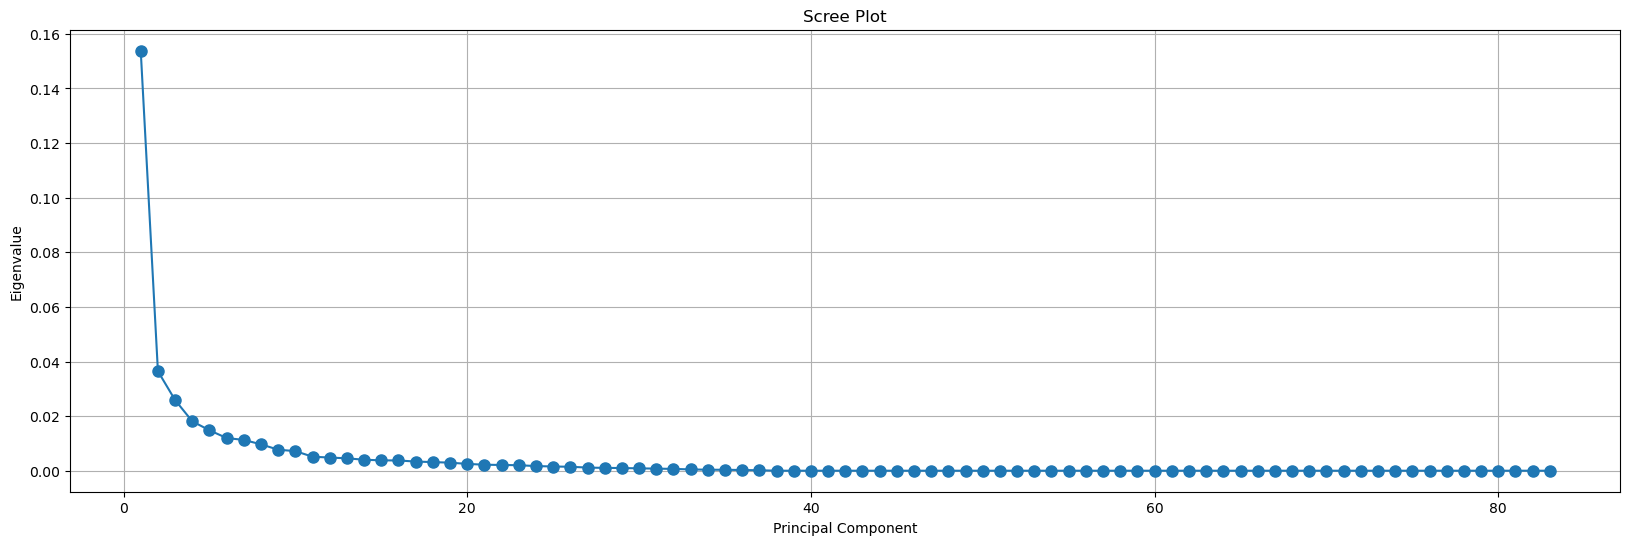

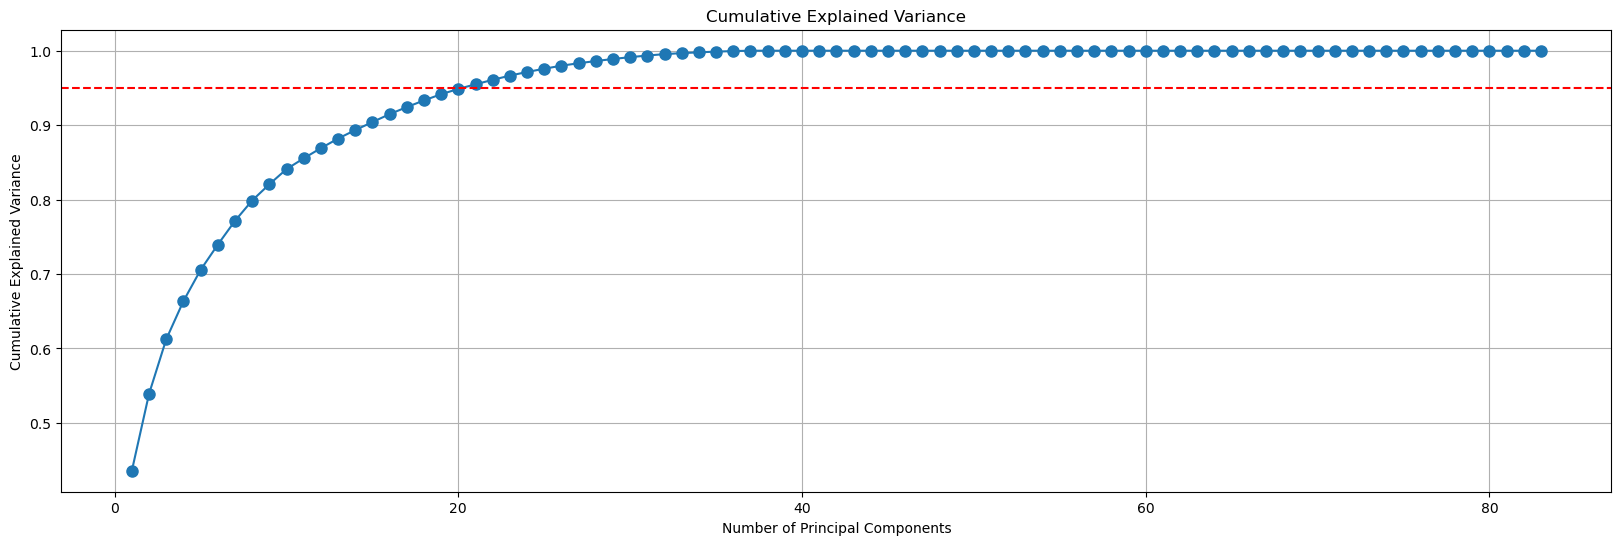

In [6]:
pca_analysis = Factor_classes.ComponentsAnalysis(stock_data.returns)
pca_analysis.plot_scree()
pca_analysis.plot_cumulative_explained_variance()

In [7]:
"""
m = 16 #explained variance 95
window_size = 36
max_iterations = 10000
factor_model = Factor_classes.APCA(returns, max_iterations=max_iterations)

U_m_final = factor_model.U_m_final
F_final = factor_model.F_final
B_final = factor_model.B_final
"""

'\nm = 16 #explained variance 95\nwindow_size = 36\nmax_iterations = 10000\nfactor_model = Factor_classes.APCA(returns, max_iterations=max_iterations)\n\nU_m_final = factor_model.U_m_final\nF_final = factor_model.F_final\nB_final = factor_model.B_final\n'

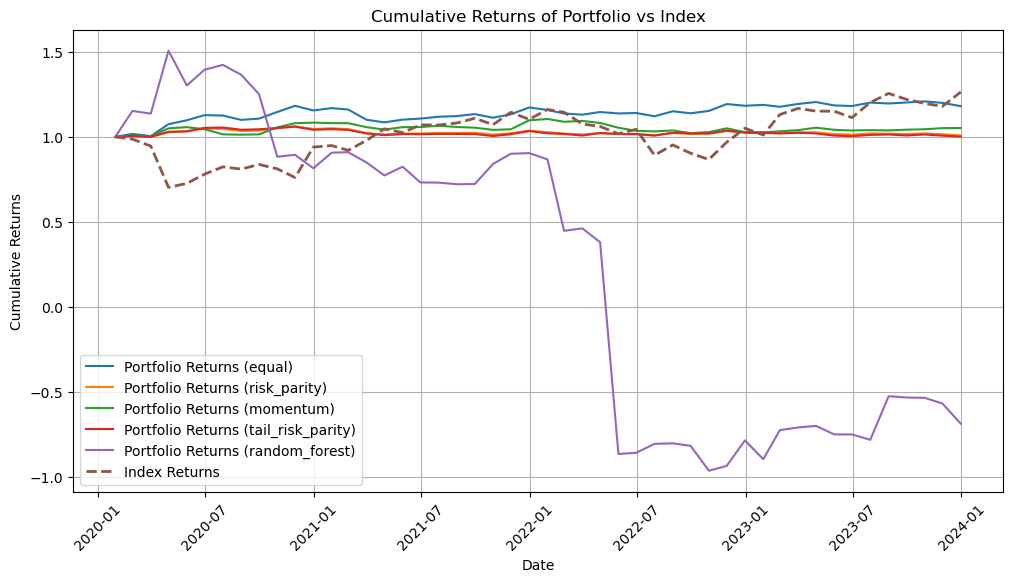

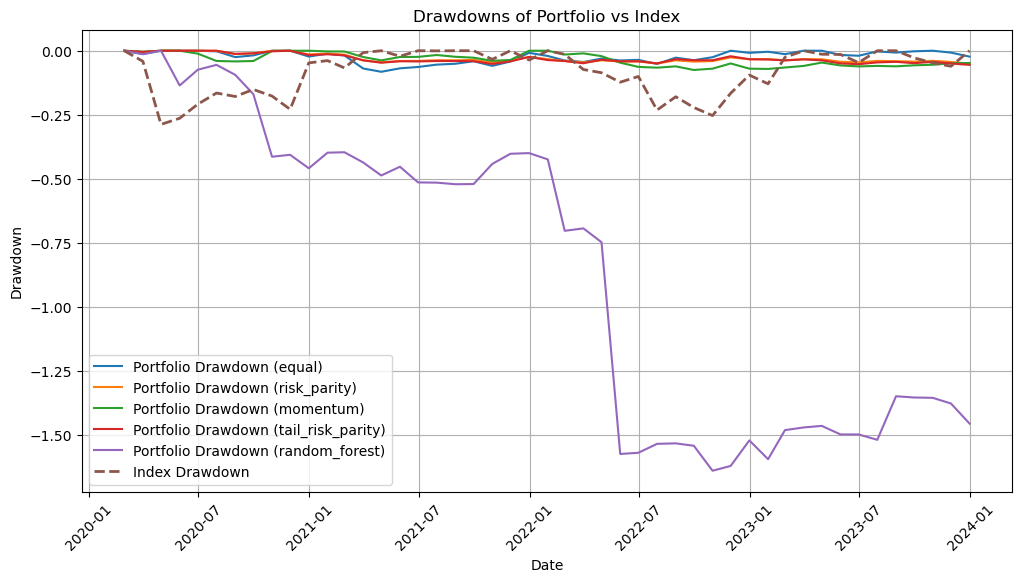

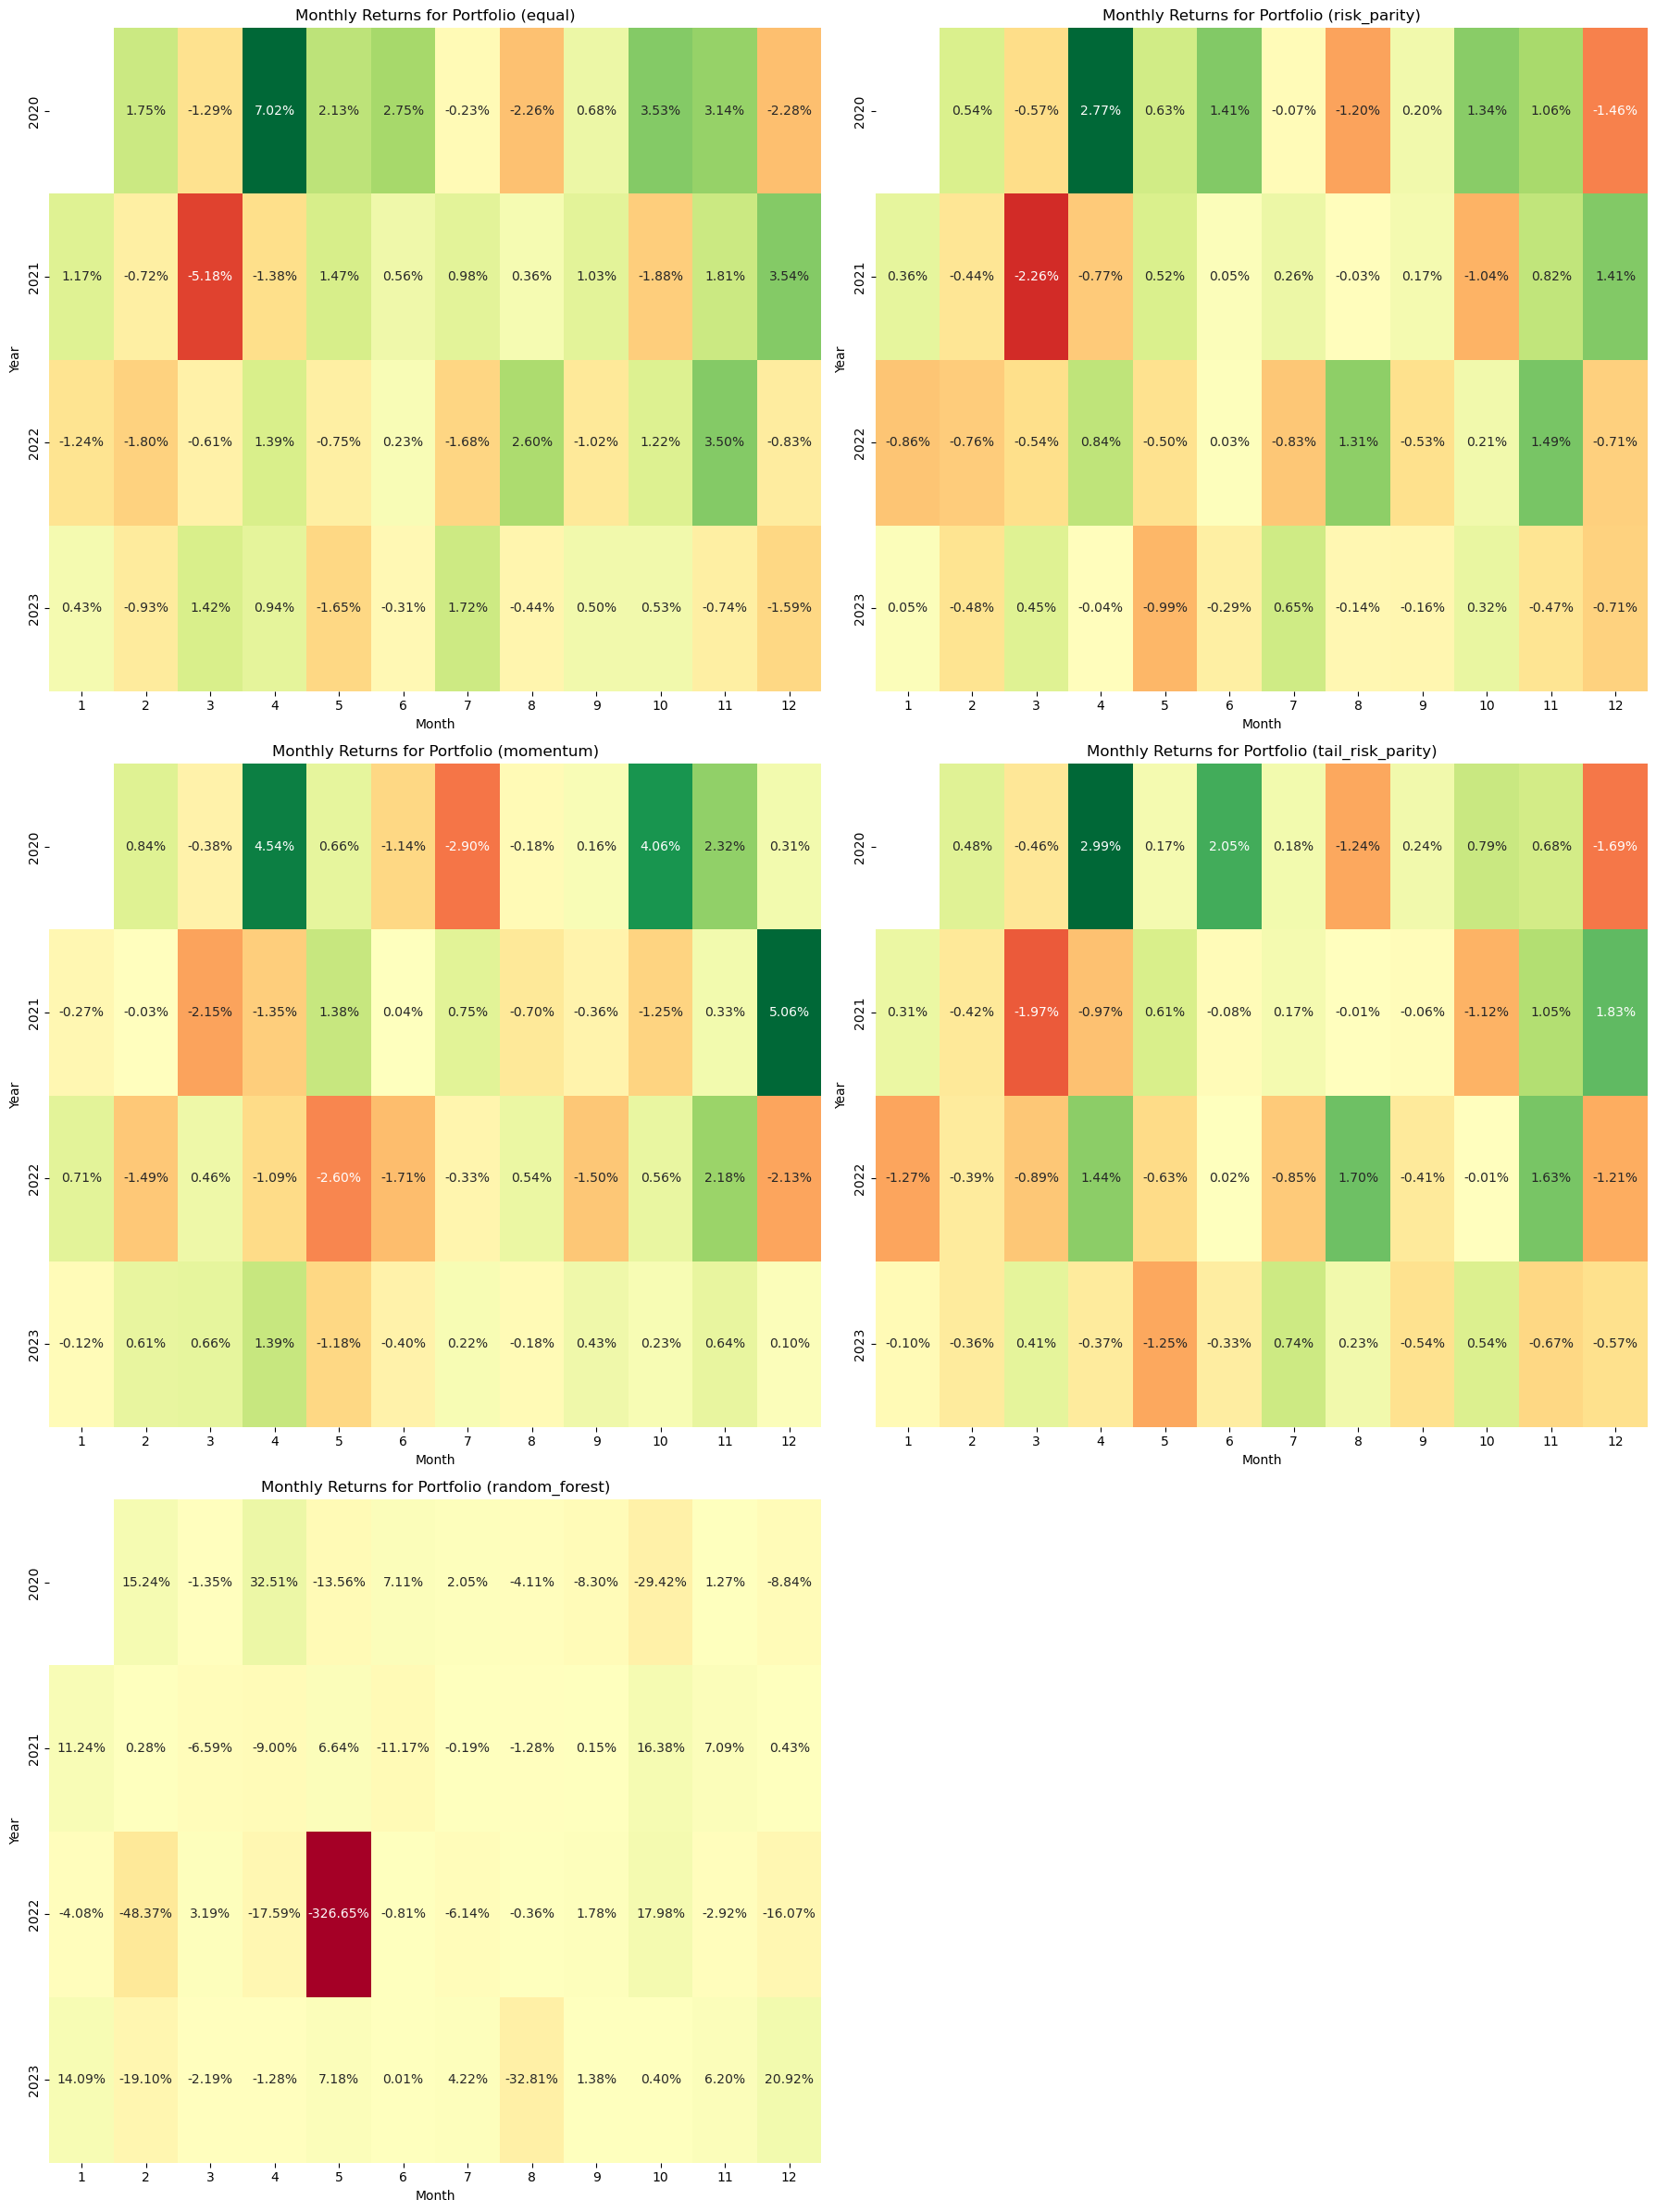

In [8]:
#con window size = 24, risultati ottimi con Random Forest
strategy = Factor_classes.RollingAPCAStrategy(returns, window_size=36, max_iterations=1000, transaction_cost=0.001, slippage=0.001)
index_cum_returns, portfolio_cum_returns = strategy.evaluate_strategies(index_returns)

In [9]:
index_test_rets = pd.DataFrame(index_cum_returns)
index_test_rets.rename(columns={'Open': 'Benchmark'}, inplace=True)

index_test_rets.head(3)

,Benchmark
Date,
2020-02-29,-0.013132
2020-03-31,-0.041379
2020-04-30,-0.256705


In [10]:
index_stats = Factor_classes.FinancialMetrics.summary_stats(index_test_rets)

index_stats

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Beta,Treynor Ratio,Tracking Error,Information Ratio,Tail Ratio
Benchmark,0.0616,0.2548,0.1835,-0.3786,6.5755,0.0622,0.1144,0.1551,0.9912,0.1204,0.1672,0.1067,0.2562,-0.2875,0.9179,1,0,0,0,1.7226


In [11]:
portfolio_test_rets = pd.DataFrame(portfolio_cum_returns)

portfolio_test_rets.head(3)

,equal,risk_parity,momentum,tail_risk_parity,random_forest
2020-02-29,0.017539,0.005433,0.008412,0.004824,0.152411
2020-03-31,-0.012919,-0.005707,-0.003831,-0.004550,-0.013542
2020-04-30,0.070170,0.027677,0.045441,0.029913,0.325092


In [12]:
portfolio_stats = Factor_classes.FinancialMetrics.summary_stats(portfolio_test_rets, market=index_test_rets)

portfolio_stats

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Beta,Treynor Ratio,Tracking Error,Information Ratio,Tail Ratio
equal,0.0433,0.0710,0.0367,0.4312,4.4797,0.0215,0.0265,0.0324,2.0155,0.1823,0.3428,0.1576,0.3994,-0.0822,2.1988,-0.0827,-0.1565,0.0820,-1.0165,1.6383
risk_parity,0.0021,0.0315,0.0174,0.3884,3.7746,0.0115,0.0134,0.0164,0.1867,-0.8595,-1.4235,-0.5356,-0.7987,-0.0506,0.1666,-0.0337,0.8050,0.0765,-1.5360,1.2284
momentum,0.0131,0.0562,0.0295,1.0020,4.8055,0.0215,0.0197,0.0255,0.6110,-0.2924,-0.5247,-0.2187,-0.3844,-0.0751,0.6974,-0.0648,0.2537,0.0798,-1.3649,1.6488
tail_risk_parity,0.0004,0.0352,0.0182,0.6401,3.4997,0.0126,0.0144,0.0164,0.0281,-0.8207,-1.4306,-0.5228,-0.8080,-0.0552,0.0251,-0.0322,0.8949,0.0766,-1.5553,1.4178
random_forest,0.0000,1.7108,2.2721,-5.8626,38.3406,0.3179,1.0379,1.3594,0.0000,0.0000,0.0000,0.0000,0.0000,-1.6386,-1.0285,0.0399,0.0000,0.4989,0.0000,0.5505


# To do

1. Controllare Random Forest
2. Provare diverse tecniche di ML
3. Ottimizzare window size